## Monte Carlo simulations of the Nagel-Schreckenberg traffic model

References:

    [1] https://arxiv.org/pdf/cond-mat/9902170
    [2] https://doi.org/10.1016/0378-4371(95)00442-4
    [3] https://doi.org/10.1103/PhysRevE.51.2939
    [4] https://en.wikipedia.org/wiki/Fundamental_diagram_of_traffic_flow

In this model, we have a single-lane road with periodic boundary conditions (a circular road, the number of cars is conserved). The road is divided into $M$ different positions, whose states can be either empty or occupied by one car only, and there are $k$ cars on the road, being $k < M$.    

Firstly, let's define a function that runs the simulation for a given set of parameters:
* _M_: number of positions on the road, takes integer values
* _N_: total number of timesteps to run, takes integer values
* _V_max_: maximum velocity allowed, takes integer values
* _k_: number of cars, takes integer values, _k <= M_
* _p_: probability of random braking, 0<p<1.
* _semilla_: to keep track of the random number generator's seed.

This function will return a numpy.array of _k_ lists, one for each car on the road, and each list will contain the position of the car for every timestep: 

In [6]:
import numpy as np
from random import seed, randint, random

def Trafic(M, N, V_max, k, p, semilla) -> np.array:
    """
    Parameters:
        M: number of positions on the road
        N: total number of timesteps
        V_max: maximum velocity
        k: number of cars
        p: probability of random braking 
        semilla: seed for the random gen.
   """ 
    seed(semilla)
    
    #Set-up inicial - autos equiespaciados excepto el primero y el último, en reposo 
    X=np.linspace(0,M-1,k,dtype=int)
    V=np.zeros(k)
    
    #Burn-in: 100 steps
    N1=100                              # Hago N1 interaciones
    for paso in range(N1):              
        for i in range(k):              # Cambio la vel. de cada auto:
            if V[i]<V_max:              # Primero aumento la velocidad
                V[i]=V[i]+1             
    
            d=(X[(i+1)%k]-X[i])%M       # Calculo la dist. al auto de adelante,
                                        # con las cond. de contorno periodicas.
            if V[i]>=d:                 # Ahora me fijo si al aumentar la vel.,
                V[i]=d-1                # hay choque con el de adelante, si hay
                                        # choque, disminuyo la vel.
                                        
            if p!=0:                    # Introduzco aleatoriedad si p!=0                                         
                frena=random()          # Tiro un número entre 0 y 1 con distr.
                                        # normal.
                if frena<=p:            # Disminuyo la vel. con una prob. p
                    V[i]=max(V[i]-1,0)
    
        for i in range(k):              # Guardo las nuevas posiciones
            X[i]=(X[i]+V[i])%M
    
    #The real simulation: N timesteps
    Pos=np.zeros((N,X.size))
    j=0
    for paso in range(N):
        for i in range(k):
            if V[i]<V_max:
                V[i]=V[i]+1
    
            d=(X[(i+1)%k]-X[i])%M
            if V[i]>=d:
                V[i]=d-1
    
            if p!=0:
                frena=random()
                if frena<=p:
                    V[i]=max(V[i]-1,0)
    
        for i in range(k):
            X[i]=(X[i]+V[i])%M
    
        # Guardo las posiciones
        Pos[j,:]=X
        j+=1
    
    return Pos

In the following sections, the fundamental diagram is calculated for $V_{max} = 1, 2, 3$, studying its functional form for various values of the braking probability _p_. The fundamental diagram of traffic flow, as defined in [4], requires plotting the traffic flow vs the traffic density. In this work, these are calculated as follows:
* $Density = \dfrac{Cars}{Length} = \dfrac{k}{M}$ 
* $Flow = Velocity \cdot Density = \dfrac{Distance}{M.N}$

Hence, the total distance traveled by all the cars is to be calculated, for a given number of cars on the road.

### **1) Without random braking: p=0**

When p=0, the flow is deterministic, since all the cars will only try to accelerate at each timestep. For a low density of cars, eventually, there will be enough empty positions ahead for every car to reach its maximum velocity, and so the stationary state will be the one with all the cars moving with $V_{i}=V_{max}$. As stated in [1], the fundamental diagram is given by

$$f(c) = \begin{cases} V_{max} \cdot c & \,,\, c \leq \frac{1}{V_{max}+1} \\ 1-c & \,,\, c > \frac{1}{V_{max}+1} \end{cases}$$

where _c_ is the traffic density, and _flow = f(c)_.

**Fundamental diagram for** **$V_{max} = 1,2,3$**

C:\Users\Juanjo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


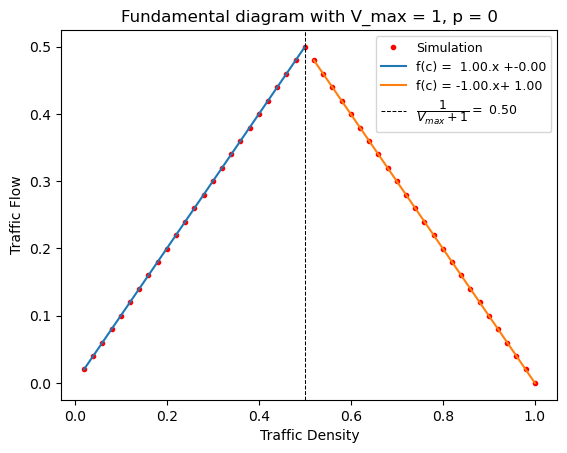

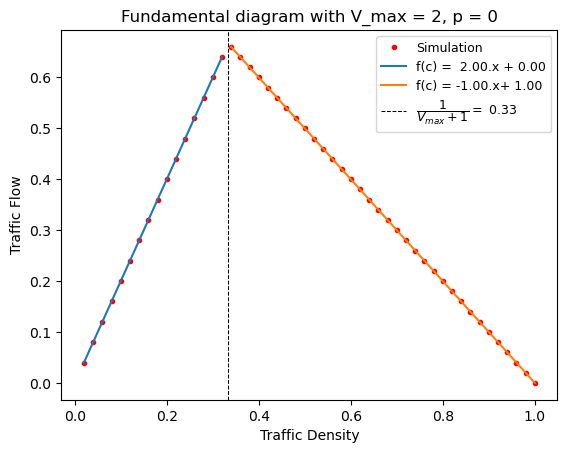

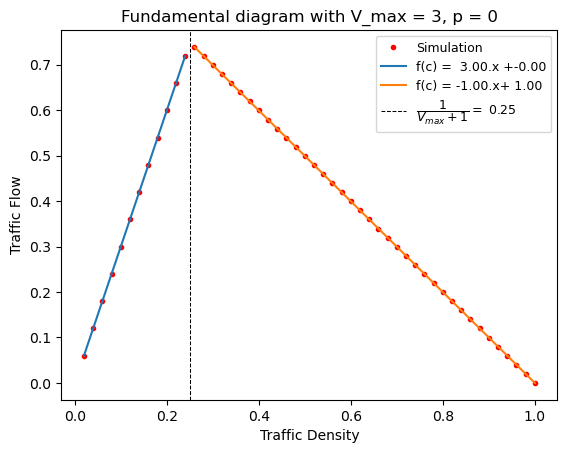

In [11]:
from matplotlib import pyplot as plt
from os import urandom
from scipy.optimize import curve_fit
import numpy as np

# Extraigo la semilla
semilla = int.from_bytes(urandom(3),'big')

for velocidad in [1,2,3]:
    largo = 1000       # Cantidad de posiciones permitidas
    tiempos = 1000     # Cantidad de pasos temporales
    V_max=velocidad
    
    # Diagrama fundamental con autos entre 20 y 1000, p=0:
    Distancias_totales = []      # La distancia total en cada simulación
    for autos in np.arange(20,1020,20):
        # Hago una simulación y la guardo en corrida
        corrida = Trafic(largo, tiempos, V_max, autos, 0, semilla)
        
        distancia_corrida = 0        # La distancia total en la corrida
        
        for i in range(autos):       # será la suma sobre el total de cada auto     
            total_cada_auto = 0
            
            for t in range(tiempos - 1):    # Calculo el avance del auto i y sumo 
                variacion = (corrida[t+1,i] - corrida[t,i])%largo
                total_cada_auto += variacion
            
            distancia_corrida += total_cada_auto
        
        Distancias_totales.append(distancia_corrida)
    
    # Calculo densidad y flujo para esa V_max:
    densidad = np.arange(20,1020,20)/largo
    flujo = [i/(largo*tiempos) for i in Distancias_totales]
    
    # Separo los valores según regimen de densidades cortando en 1/(V_max +1): 
    x_1 = []
    y_1 = []
    x_2 = []
    y_2 = []
    for i, j in zip(densidad, flujo):
        if i <= 1/(V_max+1):
            x_1.append(i)
            y_1.append(j)
        elif i >= 1/(V_max+1):
            x_2.append(i)
            y_2.append(j)
    
    # Defino una función lineal para ajustar.
    def F(x, a, b):
        return a*x + b
            
    # Ahora hago los ajustes lineales en cada uno y grafico:
    param_1, covar_1 = curve_fit(F, x_1, y_1)
    param_2, covar_2 = curve_fit(F, x_2, y_2)
    
    densidad_1 = np.linspace(min(x_1), max(x_1),100)
    densidad_2 = np.linspace(min(x_2), max(x_2),100)
    
    fig, ax = plt.subplots()
    ax.plot(densidad, flujo, 'r.', label = "Simulation")
    ax.plot(densidad_1, F(densidad_1, param_1[0], param_1[1]), label = f"f(c) = {param_1[0]: .2f}.x"
            f" +{param_1[1]: .2f}")
    ax.plot(densidad_2, F(densidad_2, param_2[0], param_2[1]), label = f"f(c) = {param_2[0]: .2f}.x"
            f"+{param_2[1]: .2f}")
    
    # Ubico el punto de corte según 1/(V_max+1)
    ax.axvline(1/(V_max+1), linewidth=0.75, linestyle="dashed", color='black', 
           label=r"$\dfrac{1}{V_{max}+1} = $"f"{1/(V_max+1): .2f}")
    
    ax.set_xlabel("Traffic Density")
    ax.set_ylabel("Traffic Flow")
    ax.set_title("Fundamental diagram with V_max = {}, p = {}".format(V_max, 0))
    ax.legend(loc="upper right", fontsize=9)

### **2) 50% chances of random braking: p=0.5**

When $0<p<1$, there is no analytical solution known for this traffic model. The authors in [3] proposed an approximation to the solution based on mean-field theory considerations. In this work we present the results of the simulations for some values of $V_{max}$.  

**Fundamental diagram for $V_{max}=1,2,3$**

In [15]:
from matplotlib import pyplot as plt
from os import urandom
import numpy as np

Diagramas=[]     # Acá guardo los diagramas por cada velocidad:
                 # [[flujo_1, densidad_1], [flujo_2, densidad_2], ...]

# Extraigo la semilla
semilla = int.from_bytes(urandom(3),'big')

for velocidad in [1,2,3]:
    largo = 1000       # Cantidad de posiciones permitidas
    tiempos = 1000     # Cantidad de pasos temporales
    V_max=velocidad
    
    # Diagrama fundamental con autos entre 10 y 1000, p=2:
    Distancias_totales = []      # La distancia total en cada simulación
    autos_totales = np.concatenate((np.arange(10,largo//(V_max+1),10),
                                    np.arange(largo//(V_max+1),1000,30)))
    for autos in autos_totales:
        # Hago una simulación y la guardo en corrida
        corrida = Trafic(largo, tiempos, V_max, autos, 0.5, semilla)
        
        distancia_corrida = 0        # La distancia total en la corrida
        
        for i in range(autos):       # será la suma sobre el total de cada auto     
            total_cada_auto = 0
            
            for t in range(tiempos - 1):    # Calculo el avance del auto i y sumo 
                variacion = (corrida[t+1,i] - corrida[t,i])%largo
                total_cada_auto += variacion
            
            distancia_corrida += total_cada_auto
        
        Distancias_totales.append(distancia_corrida)
    
    # Calculo densidad y flujo para esa V_max:
    densidad = autos_totales/largo
    flujo = [i/(largo*tiempos) for i in Distancias_totales]
    
    # Los guardo el Diagramas:
    Diagramas.append([flujo, densidad])

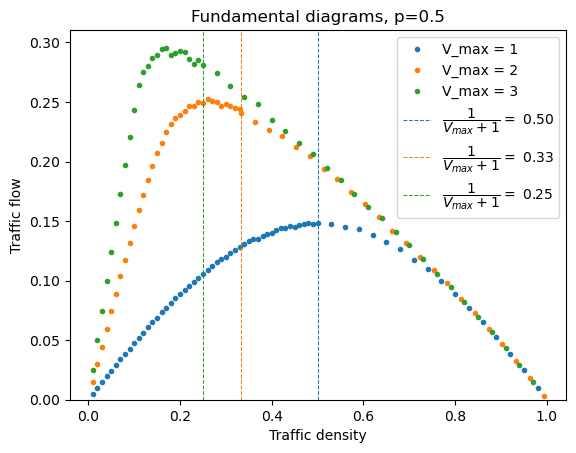

In [16]:
# Y ahora grafico todo en un mismo plot:    
    
velocidad=1
handles=[]     # Acá guardo los artists para la legend
lines=[]

fig, ax = plt.subplots()
for datos in Diagramas:
    plot, = ax.plot(datos[1], datos[0], '.', label="V_max = {}".format(velocidad)) 
    line = ax.axvline(1/(velocidad+1),ymin=0, linewidth=0.75, 
                linestyle="dashed", color=plot.get_color(), label="$\dfrac{1}{V_{max}+1}=$"f"{1/(velocidad+1): .2f}")
    
    handles.append(plot)
    lines.append(line)
    velocidad += 1 
    
ax.set_ylim(0)    
ax.set_xlabel("Traffic density")
ax.set_ylabel("Traffic flow")
ax.set_title("Fundamental diagrams, p=0.5")
ax.legend(handles=handles+lines,loc="upper right", fontsize=10)   
plt.show()

The vertical lines in the plot show the traffic density corresponding to the maximum flow calculated in the deterministic case, when $p=0$. It can be seen that, except for $V_{max}=1$, the flow starts decreasing for a lower number of cars in the road when there is random behaviour from the drivers. 

Moreover, the maximum value of the flow is lower than it was when $p=0$. For example, let's plot both $p=0$ and $p=0.5$ cases for $V_{max}=1$:

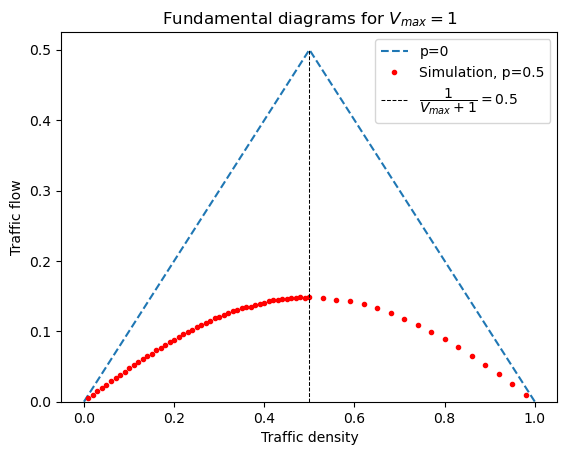

In [18]:
# Defino la función correspondiente a p=0, V_max=1:
def f(x):
    if x <= 0.5: 
        return x
    else:
        return 1-x

# Grafico la simulación con p=0.5 junto con la función a p=0:
x = np.linspace(0,1,5001)
plt.plot(x, [f(i) for i in x],'--', label="p=0")
plt.plot(Diagramas[0][1], Diagramas[0][0], 'r.', label="Simulation, p=0.5")
plt.vlines(0.5, linewidth=0.75, ymin=0, ymax=f(0.5), linestyles="dashed", color='black', 
           label=r"$\dfrac{1}{V_{max}+1} = 0.5$")


plt.xlabel("Traffic density")
plt.ylabel("Traffic flow")
plt.ylim(0)
plt.title("Fundamental diagrams for $V_{max}=1$")
plt.legend()
plt.show()

It is easy to see that the maximum flow value decreased about a 70% when a 50% chance of random braking is taken into account.

### **3) Simulations and analytical results for $V_{max}=1$**

The authors in [1],[2] proposed a mean-field theory approach to the problem and found an exact analytical solution when $V_{max}=1$, which reads

$$ f(c,p) = \dfrac{1}{2} \left( 1-\sqrt{1-4(1-p)(1-c)c} \right) $$

where _c_ is the traffic density and _p_ is the probability of random braking.

Let's plot some simulation's results along with the function given above.

In [22]:
def g(x,p):
    """
    Traffic flow function for V_max=1
    p: braking prob., 0<p<1
    x: flow density
    """
    return (1-np.sqrt(1-4*(1-p)*(1-x)*x))/2

In [23]:
# Hago las simulaciones y guardo los resultados para p=0.5, p=0.25, p=0.1 :
from matplotlib import pyplot as plt
from os import urandom
import numpy as np

Diagramas=[]     # Acá guardo los diagramas por p:
                 # [[densidad_1, flujo_1], [densidad_2, flujo_2],...]

# Extraigo la semilla
semilla = int.from_bytes(urandom(3),'big')

for p in [0.5, 0.25, 0.1]:
    largo = 1000       # Cantidad de posiciones permitidas
    tiempos = 1000     # Cantidad de pasos temporales
    V_max=1
    
    # Diagrama fundamental con autos entre 10 y 1000
    Distancias_totales = []      # La distancia total en cada simulación
    autos_totales = np.concatenate((np.arange(10,largo//(V_max+1),10),
                                    np.arange(largo//(V_max+1),1000,30)))
    for autos in autos_totales:
        # Hago una simulación y la guardo en corrida
        corrida = Trafic(largo, tiempos, V_max, autos, p, semilla)
        
        distancia_corrida = 0        # La distancia total en la corrida
        
        for i in range(autos):       # será la suma sobre el total de cada auto     
            total_cada_auto = 0
            
            for t in range(tiempos - 1):    # Calculo el avance del auto i y sumo 
                variacion = (corrida[t+1,i] - corrida[t,i])%largo
                total_cada_auto += variacion
            
            distancia_corrida += total_cada_auto
        
        Distancias_totales.append(distancia_corrida)
    
    # Calculo densidad y flujo para ese valor de p:
    densidad = autos_totales/largo
    flujo = [i/(largo*tiempos) for i in Distancias_totales]
    
    # Los guardo en Diagramas:
    Diagramas.append([densidad, flujo])

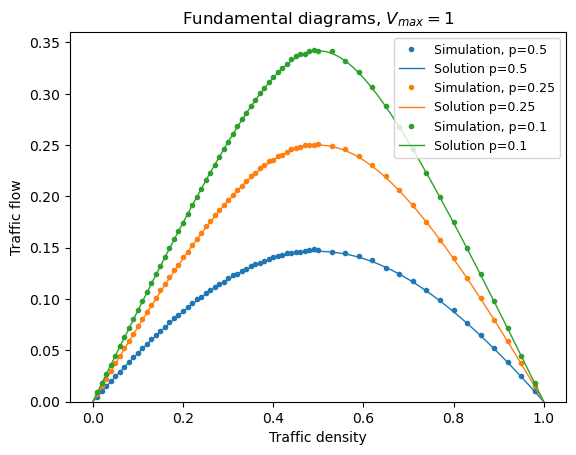

In [25]:
# Y ahora grafico los resultados junto con la función propuesta:

x = np.linspace(0,1,5001)

fig, ax = plt.subplots()
for datos, p in zip(Diagramas,[0.5, 0.25, 0.1]):
    plot, = ax.plot(datos[0],datos[1], '.', label="Simulation, p={}".format(p))     
    ax.plot(x, [g(i,p) for i in x], linewidth=1,
            color=plot.get_color(), label="Solution p={}".format(p))
    
ax.set_ylim(0)    
ax.set_xlabel("Traffic density")
ax.set_ylabel("Traffic flow")
ax.set_title("Fundamental diagrams, $V_{max} = 1$")
ax.legend(loc="upper right", fontsize=9)   
plt.show()

The solution presents good agreement with the Monte Carlo simulations.

In addition, the plots show for $V_{max}=1$ that the functions are symmetric with respect to $x=0.5$, which reflects the particle-hole symmetry of the model in this case [1]. This can be understood from the fact that, under the $V_{max}=1$ condition, a hole is created every time a car moves, and it cannot be filled in that same timestep because that would create a state with two adjacent cars with velocity 1, which is impossible to be obtained dynamically given the defined set of rules. These forbidden states are called Garden of Eden States and are discussed in [1].

These features of the model with $V_{max}=1$ make it fairly unrealistic, even with $p \neq 0$

### **4) Simulations for $V_{max}=2$**

For $V_{max}>1$, the mean-field theory approach attempted by the authors in [1],[2] does not give exact results, but rather approximations. As discussed in Section 2), the correlations between cars grow stronger for $p \neq 0$, and therefore the maximum flow decreases and so does its corresponding density.

Lets plot the simulations for $V_{max}=2$ with different values of p.

In [30]:
# Hago las simulaciones y guardo los resultados para p=0.5, p=0.25, p=0.1 :
from matplotlib import pyplot as plt
from os import urandom
import numpy as np

Diagramas=[]     # Acá guardo los diagramas por p:
                 # [[densidad_1, flujo_1], [densidad_2, flujo_2],...]

# Extraigo la semilla
semilla = int.from_bytes(urandom(3),'big')

for p in [0.5, 0.25, 0.1]:
    largo = 1000       # Cantidad de posiciones permitidas
    tiempos = 1000     # Cantidad de pasos temporales
    V_max=2
    
    # Diagrama fundamental con autos entre 10 y 1000
    Distancias_totales = []      # La distancia total en cada simulación
    autos_totales = np.concatenate((np.arange(10,largo//(V_max+1),10),
                                    np.arange(largo//(V_max+1),1000,30)))
    for autos in autos_totales:
        # Hago una simulación y la guardo en corrida
        corrida = Trafic(largo, tiempos, V_max, autos, p, semilla)
        
        distancia_corrida = 0        # La distancia total en la corrida
        
        for i in range(autos):       # será la suma sobre el total de cada auto     
            total_cada_auto = 0
            
            for t in range(tiempos - 1):    # Calculo el avance del auto i y sumo 
                variacion = (corrida[t+1,i] - corrida[t,i])%largo
                total_cada_auto += variacion
            
            distancia_corrida += total_cada_auto
        
        Distancias_totales.append(distancia_corrida)
    
    # Calculo densidad y flujo para ese valor de p:
    densidad = autos_totales/largo
    flujo = [i/(largo*tiempos) for i in Distancias_totales]
    
    # Los guardo en Diagramas:
    Diagramas.append([densidad, flujo])

In [31]:
# Primero busco el máximo con un ajuste spline cúbico, para cada simulación
from scipy.interpolate import CubicSpline as cubfit

maximos = [] # Acá guardo los máximos obtenidos en cada caso:
             # [(x_1, y_1), (x_2, y_2), ...]
functions = []  # Voy a guardar también las funciones spline

# Voy a calcular para cada simulación: 
for datos in Diagramas:
    fit = cubfit(datos[0], datos[1])   # Acá obtengo la función tras el ajuste
    
    functions.append(fit)
    deriv = fit.derivative()           # Calculo la derivada de la función spline
    func_values={}                     # Acá voy a guardar los puntos críticos
    for i in deriv.roots():            # Y acá calculo las raices de la derivada 
        if i>0 and i<1/(V_max+1):         
            fun_eval = fit(i)                              # Evalúo la función en la i root
            func_values.update({float(fun_eval): i})    # La almaceno en un diccionario: {f(i):i}
        
    y_max = max(func_values.keys())  # Obtengo el máximo valor de f
    x_max = func_values[y_max]       # Obtengo el x corresp. al máximo        
    maximos.append([x_max, y_max])      # Y acá guardo el punto máximo

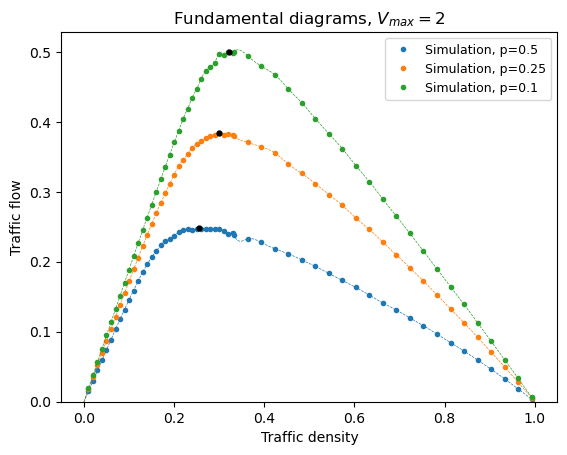

In [32]:
# Grafico simulacion para cada p, junto con el punto máximo.     

x = np.linspace(0,1,5001)
fig, ax = plt.subplots()
for datos, p, coord_max, f in zip(Diagramas,[0.5, 0.25, 0.1] , maximos, functions):  
    plot, = ax.plot(datos[0],datos[1], '.', label="Simulation, p={}".format(p))
    ax.plot(x, f(x), "--", linewidth=0.5, color=plot.get_color())
    ax.plot(coord_max[0], coord_max[1], '.', color="0", markersize=7)

    
ax.set_ylim(0)    
ax.set_xlabel("Traffic density")
ax.set_ylabel("Traffic flow")
ax.set_title("Fundamental diagrams, $V_{max} = 2$")
ax.legend(loc="upper right", fontsize=9)   
plt.show()